# Projeto Final - Aprendizagem de Máquina

- Thiago Martin Poppe
- Matrícula: 2017014324

# 1) Introdução

## 1.1) Dataset
- Foi utilizado um dataset presente no site [Kaggle](https://www.kaggle.com/jonathanbesomi/superheroes-nlp-dataset) que consiste em dados sobre super-heróis e vilões incluindo, por exemplo, nome, poderes, história, criador (editora), entre outros.

## 1.2) Tarefas pensadas
1. Dado a história do personagem, determinar se este é originado da ``Marvel Comics`` ou da ``DC Comics``.
2. Explicar o que o classificador aprendeu durante o treinamento utilizando explicabilidade de modelo.
3. Visualizar no espaço as classes e palavras relacionadas com cada editora.

## 1.3) Imports

In [1]:
import re
import nltk
import string
import warnings

# Filtrando warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from tqdm.notebook import tqdm
from eli5.lime import TextExplainer
from IPython.display import display

# # Downloads necessários para utilizar os módulos da biblioteca NTLK.
# # Caso não os tenha favor descomentar as próximas linhas
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')

# Para utilizar progress_apply
tqdm.pandas()

# Fixando random seed
np.random.seed(42)

Using TensorFlow backend.


# 2) Visão geral dos dados

## 2.1) Leitura dos dados

In [2]:
# Lendo os dados e filtrando apenas aqueles com criadores Marvel Comics e DC Comics
df = pd.read_csv('CustomDatasets/History.csv')
df = df[df['creator'].isin(['Marvel Comics', 'DC Comics'])]

# Tornando o nome do personagem como o index do DataFrame
df = df.set_index('name')

print('Dimensões do DataFrame', df.shape)
df.head(5)

Dimensões do DataFrame (914, 3)


,real_name,history_text,creator
name,,,
3-D Man,"Delroy Garrett, Jr.","Delroy Garrett, Jr. grew up to become a track ...",Marvel Comics
514A (Gotham),Bruce Wayne,He was one of the many prisoners of Indian Hil...,DC Comics
A-Bomb,Richard Milhouse Jones,"Richard ""Rick"" Jones was orphaned at a young ...",Marvel Comics
Aa,Aa,Aa is one of the more passive members of the P...,DC Comics
Aaron Cash,Aaron Cash,Aaron Cash is the head of security at Arkham A...,DC Comics


## 2.3) Distribuição de classes

In [3]:
creator_counter = df['creator'].value_counts()
creator_counter

Marvel Comics    536
DC Comics        378
Name: creator, dtype: int64

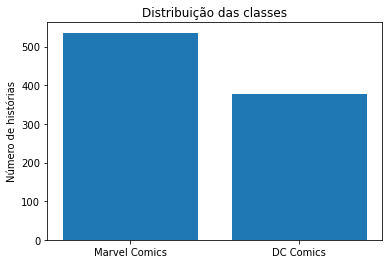

In [4]:
plt.bar(['Marvel Comics', 'DC Comics'], creator_counter)

plt.title('Distribuição das classes')
plt.ylabel('Número de histórias')
plt.show()

## 2.4) Exemplo de uma história

In [5]:
batman = df.loc['Batman (Burtonverse)']

print('Batman foi criado pela', batman['creator'], end='\n\n')
print(batman['history_text'])

Batman foi criado pela DC Comics

Bruce Wayne is a billionaire playboy from Gotham City. When eight years old, he saw his parents get murdered in front of him. He spent seven years of his adult life in training in various forms of martial arts, and his detective skills. When he returned, he was inspired by a bat in his ancestral home of Wayne Manor. He became Batman. During his time as Batman, he had engaged with a lot of criminals and terrorrists, such as Joker, Penguin, Catwoman, Two-Face, Riddler, Mister Freeze, Poison Ivy, and Bane. And his act as Gotham's protector was not all alone, since he had helped by Alfred, Robin, and Batgirl.


# 3) Pré-processamento dos dados

- Para todo pré-processamento utilizo a biblioteca ``NLTK (Natural Language Toolkit)`` por simplicidade. Também utilizo algumas bibliotecas padrões do Python, como por exemplo ``string``.<br><br>

- O pré-processamento de cada texto será feito em 5 etapas:
    - Conversão o texto em caracteres minúsculos.
    - Tokenização do texto.
    - Remoção de pontuações.
    - Remoçao de ``stopwords``.
    - Lematização de verbos e substantivos. <br><br>

- A tokenização consiste em transformar uma frase em um vetor de palavras. Por exemplo, a frase: ``It's impossible`` é convertida para ``[It, 's, impossible]``.<br><br>

- ``Stopwords`` são artigos, preposições e outras palavras que não contribuem muito para o ganho de informação no texto. Nem sempre a remoção de stopwords pode ser algo bom. Quando queremos aprender uma característica do escritor, como uso de artigos e preposições, a remoção de tais palavras pode não ser recomendado.<br><br>

- Lematização é a deflexição uma palavra para determinar o seu lema. Em português, por exemplo, as palavras era, sou e somos são do mesmo lema ser.

## 3.1) Funções

In [6]:
wnl = WordNetLemmatizer() # classe para lematização
lemmatized_tokens = dict() # para agilizar a lematização de tokens
english_stopwords = set(stopwords.words('english')) # Stopwords da língua inglesa

pos_encoder = {
    'N': wordnet.NOUN,
    'V': wordnet.VERB,
    'J': wordnet.ADJ,
    'R': wordnet.ADV
}

In [7]:
def get_POS(word):
    """ Função para encontrar corretamente o POS (Parts of Speech) de uma palavra """
    
    tag = nltk.pos_tag([word])[0][1][0]
    return pos_encoder.get(tag, wordnet.NOUN) # por default retornamos substantivo

def remove_punctuation(s):
    """ Função para remover pontuação de uma string tokenizada """
    
    for punct in string.punctuation:
        s = [token.replace(punct, '') for token in s]
    
    # Filtrando valores vazios
    return [token for token in s if token is not '']


def remove_stopwords(s):
    """ Função para remover stopwords de uma string tokenizada """
    
    return [token for token in s if token not in english_stopwords]


def lemmatization(s):
    """ Função para lematizar uma string tokenizada, retornando uma string """
    
    lemma = []
    for token in s:
        if token not in lemmatized_tokens:
            lemmatized_tokens[token] = wnl.lemmatize(token, get_POS(token))
        lemma.append(lemmatized_tokens[token])
            
    return ' '.join(token for token in lemma)

def pre_processing(s):
    """ Função que realiza o pipeline de pré-processamento em uma string """
    
    s = s.lower()
    s = word_tokenize(s)
    s = remove_punctuation(s)
    s = remove_stopwords(s)
    return lemmatization(s)

## 3.2) Exemplo de pré-processamento

- Como exemplo utilizaremos a mesma história mostrada na seção 2.4 (Exemplo de uma história).

In [8]:
history = batman['history_text']

print('- História original:')
print(history, end='\n\n')

history = history.lower()
print('- História em minúsculo:')
print(history, end='\n\n')

history = word_tokenize(history)
print('- História em tokens:')
print(history, end='\n\n')

history = remove_punctuation(history)
print('- História sem pontuação:')
print(history, end='\n\n')

history = remove_stopwords(history)
print('- História sem stopwords:')
print(history, end='\n\n')

history = lemmatization(history)
print('- História lematizada:')
print(history)

- História original:
Bruce Wayne is a billionaire playboy from Gotham City. When eight years old, he saw his parents get murdered in front of him. He spent seven years of his adult life in training in various forms of martial arts, and his detective skills. When he returned, he was inspired by a bat in his ancestral home of Wayne Manor. He became Batman. During his time as Batman, he had engaged with a lot of criminals and terrorrists, such as Joker, Penguin, Catwoman, Two-Face, Riddler, Mister Freeze, Poison Ivy, and Bane. And his act as Gotham's protector was not all alone, since he had helped by Alfred, Robin, and Batgirl.

- História em minúsculo:
bruce wayne is a billionaire playboy from gotham city. when eight years old, he saw his parents get murdered in front of him. he spent seven years of his adult life in training in various forms of martial arts, and his detective skills. when he returned, he was inspired by a bat in his ancestral home of wayne manor. he became batman. duri

# 4) Codificação dos dados

- Para a codificação dos dados, especificamente para os textos, utilizarei a biblioteca ``scikit-learn`` que já possui classes de extrações de features para os mesmos.

## 4.1) Codificação das labels

- Podemos fazer a codificação das labels através de um dicionário em Python. Nele, a classe ``Marvel Comics`` assumirá valor 0; enquanto que ``DC Comics`` valor 1.

In [9]:
encoder = {'Marvel Comics': 0, 'DC Comics': 1}

creators = df['creator'].values[:5]
labels = [encoder[label] for label in creators]

print(creators)
print(labels)

['Marvel Comics' 'DC Comics' 'Marvel Comics' 'DC Comics' 'DC Comics']
[0, 1, 0, 1, 1]


## 4.2) CountVectorize

- A classe ``CountVectorize`` converte cada string para o número de repetições da mesma em um documento. Como lematizamos os verbos e substantivos, palavras como Vingadores e Vingador, por exemplo, serão tratadas como a mesma palavra vingador. Com isso, teremos uma contagem mais correta das palavras no documento. <br><br>

- Para exemplificar, utilizaremos a mesma história mostrada na seção 2.4 (Exemplo de uma história), exibindo as 5 palavras que mais se repetiram no texto.

In [10]:
vectorizer = CountVectorizer()
history = pre_processing(batman['history_text'])

features = vectorizer.fit_transform([history]).todense()

In [11]:
names  = vectorizer.get_feature_names()
values = np.array(features)[0]

zipped = sorted(zip(names, values), key=lambda x: x[1], reverse=True)[:5]
print([(string, value) for string, value in zipped])

[('batman', 2), ('gotham', 2), ('wayne', 2), ('year', 2), ('act', 1)]


## 4.3) TF-IDF Vectorizer

- A classe ``TfidfVectorizer``, ou ``Term Frequency – Inverse Document Frequency Vectorizer``, pode ser divido em 2 operações:
    - *Term Frequency*: Representa uma sumarização de quão frequente uma palavra aparece em um documento.
    - *Inverse Document Frequency*: Penaliza palavras que aparecem muito ao longo dos documentos, sendo vistas como palavras "não interessantes". Isso pode ser feito para penalizar palavras como artigos e preposições, por exemplo.<br><br>
    
- Essa representação é mais robusta que a ``CountVectorizer``, porém, para o nosso caso, suponho que o seu uso resultará em uma acurácia menor ou igual à apresentada pelo ``CountVectorizer``. Essa suposição é feita visto que, já filtramos as palavras "não interessantes" e o ``Inverse Document Frequency`` pode achar que palavras como ``Gotham`` não são interessantes por repetirem muito em alguns textos da ``DC Comics``. Para isso, iremos realizar uma comparação entre as duas codificações posteriormente. <br><br>

- Para exemplificar, utilizaremos a mesma história mostrada na seção 2.4 (Exemplo de uma história), exibindo as 5 palavras que mais se repetiram no texto.

In [12]:
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform([history]).todense()

In [13]:
names  = vectorizer.get_feature_names()
values = np.array(features)[0]

zipped = sorted(zip(names, values), key=lambda x: x[1], reverse=True)[:5]
print([(string, value) for string, value in zipped])

[('batman', 0.24253562503633297), ('gotham', 0.24253562503633297), ('wayne', 0.24253562503633297), ('year', 0.24253562503633297), ('act', 0.12126781251816648)]


# 5) Separação dos dados em features e labels

In [14]:
# Pré-processando histórias
print('Pré-processando as histórias...')
df['history_text'] = df['history_text'].progress_apply(lambda x: pre_processing(x))
X = df['history_text'].values
    
# Codificando as labels
print('Codificando as labels...')
y = np.array([encoder[label] for label in tqdm(df['creator'].values)])

Pré-processando as histórias...



Codificando as labels...


# 5) Classificação

- Para a classificação, usaremos 6 modelos vistos em sala de aula, sendo eles: SVM (Support Vector Machine), Regressão Logística, Árvore de Decisão, Gradient Tree Boosting, Random Forest e Naive Bayes. Usaremos a biblioteca ``scikit-learn`` que já possui tais modelos implementados.<br><br>
    
- Como forma de validação usaremos a validação-cruzada com 5 folds. Para avaliar os modelos utilizaremos as métricas de acurácia, precisão e recall.

In [15]:
# Fixamos o random_state para termos uma comparação igualitária entre os modelos
kf = KFold(n_splits=5, shuffle=True, random_state=42)
print('Número de folds =', kf.n_splits)

Número de folds = 5


## 5.1) Funções auxiliares

In [16]:
def validate_classifier(clf, vct, naive_bayes=False):
    """ 
        Função auxiliar para validar um classificador
        
        - Parâmetros:
            - clf : Classificador
            - vct : Codificação das features (CountVectorizer ou TfidfVectorizer)
            
        - Retorno:
            - Dicionário contendo as métricas calculadas
    """
    
    train_acc = []
    val_acc   = []
    precision = []
    recall    = []

    for train, val in kf.split(X, y):
        # Codificando as features através do vectorizer
        vectorizer = vct
        vectorizer.fit(X[train])
        X_train = vectorizer.transform(X[train])
        X_val = vectorizer.transform(X[val])
        
        if naive_bayes:
            X_train = X_train.todense()
            X_val = X_val.todense()
        
        # "Fitando" classificador
        clf.fit(X_train, y[train])

        # Computando métricas do treino
        preds = clf.predict(X_train)
        train_acc.append(metrics.accuracy_score(y[train], preds))

        # Computando métricas da validação
        preds = clf.predict(X_val)
        val_acc.append(metrics.accuracy_score(y[val], preds))
        precision.append(metrics.precision_score(y[val], preds))
        recall.append(metrics.recall_score(y[val], preds))

    # Retornando a média das métricas
    return {
        'Train Accuracy': np.mean(train_acc),
        'Validation Accuracy': np.mean(val_acc),
        'Precision': np.mean(precision),
        'Recall': np.mean(recall)
    }
    


def plot_accuracy(title, xlabel, xvals, train_acc, val_acc):
    """
        Função auxiliar para plotar a acurácia de um classificador no treino e validação
        
        - Parâmetros:
            - title: string (título do plot)
            - xlabel: string (label do eixo x)
            - xvals: list (lista contendo valores do eixo x)
            - train_acc : list (lista de acurácias no treino)
            - val_acc : list (lista de acurácias na validação)
    """
    
    plt.title(title)
    plt.ylabel('Acurácia')
    plt.xlabel(xlabel)

    plt.plot(xvals, train_acc, label='Treino')
    plt.plot(xvals, val_acc, label='Validação')
    plt.legend()
    plt.show()
    
    
    
def build_table(results):
    """
        Função para gerar uma tabela de resultados
        
        - Parâmetros:
            - metrics: dicionário contendo as métricas calculadas para o classificador
    """
    
    cols = ['Train Accuracy', 'Validation Accuracy', 'Recall', 'Precision']
    return pd.DataFrame.from_dict(results, orient='index')

## 5.2) SVM (Support Vector Machine)

In [17]:
tables = []
    
for vct in ['Count', 'TF-IDF']:
    param_metrics = {}
    kernels = ['linear', 'sigmoid', 'poly', 'rbf']
    vectorizer = CountVectorizer() if vct is 'Count' else TfidfVectorizer()
    
    print('\nCodificação:', vct)
    print('Validando SVM para cada kernel...')
    for k in tqdm(kernels):
        clf = SVC(kernel=k)
        param_metrics[k] = validate_classifier(clf, vectorizer)

    tables.append(build_table(param_metrics))
    
print('Métricas utilizando CountVectorizer:')
display(tables[0])

print('\n\nMétricas utilizando TfidfVectorizer:')
display(tables[1])


Codificação: Count
Validando SVM para cada kernel...




Codificação: TF-IDF
Validando SVM para cada kernel...



Métricas utilizando CountVectorizer:


,Train Accuracy,Validation Accuracy,Precision,Recall
linear,1.000000,0.880760,0.845474,0.868331
sigmoid,0.728942,0.707914,0.916547,0.326330
poly,0.637315,0.591971,0.488571,0.045101
rbf,0.751361,0.685000,1.000000,0.243039




Métricas utilizando TfidfVectorizer:


,Train Accuracy,Validation Accuracy,Precision,Recall
linear,0.999180,0.954056,0.963721,0.925141
sigmoid,0.998632,0.949685,0.966423,0.911438
poly,1.000000,0.653276,1.000000,0.166792
rbf,1.000000,0.922356,0.978229,0.836496


## 5.3) Regressão Logística

In [18]:
tables = []
    
for vct in ['Count', 'TF-IDF']:
    param_metrics = {}
    vectorizer = CountVectorizer() if vct is 'Count' else TfidfVectorizer()
    
    print('\nCodificação:', vct)
    print('Validando Regressão Logística...')
    clf = LogisticRegression()
    param_metrics[vct] = validate_classifier(clf, vectorizer)

    tables.append(build_table(param_metrics))
    
display(pd.concat(tables))


Codificação: Count
Validando Regressão Logística...

Codificação: TF-IDF
Validando Regressão Logística...


,Train Accuracy,Validation Accuracy,Precision,Recall
Count,1.000000,0.917955,0.898512,0.905399
TF-IDF,0.993982,0.904846,0.989815,0.783075


## 5.4) Árvore de Decisão


Codificação: Count
Validando Árvore de Decisão para cada altura...




Codificação: TF-IDF
Validando Árvore de Decisão para cada altura...


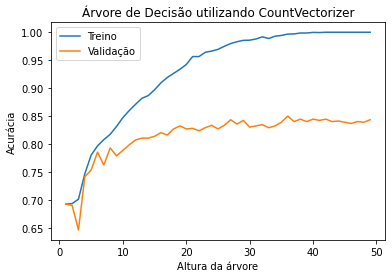

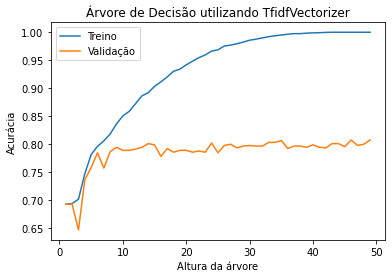

In [19]:
results = []

for vct in ['Count', 'TF-IDF']:
    param_metrics = {}
    heights = list(range(1, 50))
    heights.append(None)
    vectorizer = CountVectorizer() if vct is 'Count' else TfidfVectorizer()
    
    train_acc = []
    val_acc = []
    
    print('\nCodificação:', vct)
    print('Validando Árvore de Decisão para cada altura...')
    for h in tqdm(heights):
        clf = DecisionTreeClassifier(max_depth=h)
            
        param_metrics[h] = validate_classifier(clf, vectorizer)
        train_acc.append(param_metrics[h]['Train Accuracy'])
        val_acc.append(param_metrics[h]['Validation Accuracy'])
    
    results.append([train_acc, val_acc])
    
train_acc = results[0][0]
val_acc = results[0][1]
plot_accuracy('Árvore de Decisão utilizando CountVectorizer', 'Altura da árvore', heights, train_acc, val_acc)

train_acc = results[1][0]
val_acc = results[1][1]
plot_accuracy('Árvore de Decisão utilizando TfidfVectorizer', 'Altura da árvore', heights, train_acc, val_acc)

## 5.5) Gradient Tree Boosting


Codificação: Count
Validando Gradient Tree Boosting para diferentes iterações...




Codificação: TF-IDF
Validando Gradient Tree Boosting para diferentes iterações...


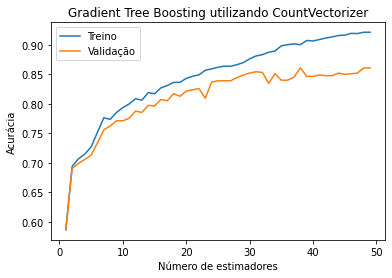

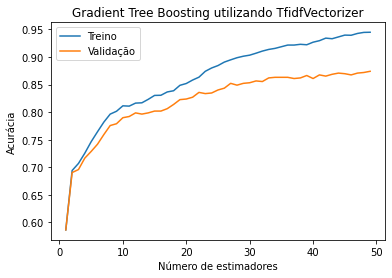

In [20]:
results = []

for vct in ['Count', 'TF-IDF']:
    param_metrics = {}
    iters = range(1, 50)
    vectorizer = CountVectorizer() if vct is 'Count' else TfidfVectorizer()
    
    train_acc = []
    val_acc = []
    
    print('\nCodificação:', vct)
    print('Validando Gradient Tree Boosting para diferentes iterações...')
    for i in tqdm(iters):
        clf = GradientBoostingClassifier(n_estimators=i)
            
        param_metrics[h] = validate_classifier(clf, vectorizer)
        train_acc.append(param_metrics[h]['Train Accuracy'])
        val_acc.append(param_metrics[h]['Validation Accuracy'])
    
    results.append([train_acc, val_acc])
    
train_acc = results[0][0]
val_acc = results[0][1]
plot_accuracy('Gradient Tree Boosting utilizando CountVectorizer', 'Número de estimadores', iters, train_acc, val_acc)

train_acc = results[1][0]
val_acc = results[1][1]
plot_accuracy('Gradient Tree Boosting utilizando TfidfVectorizer', 'Número de estimadores', iters, train_acc, val_acc)

## 5.6) Random Forest


Codificação: Count
Validando Random Forest para diferentes iterações...




Codificação: TF-IDF
Validando Random Forest para diferentes iterações...


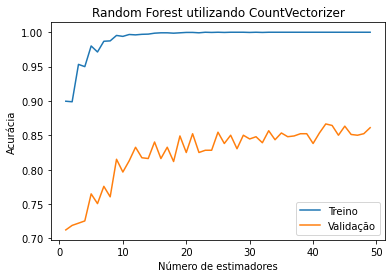

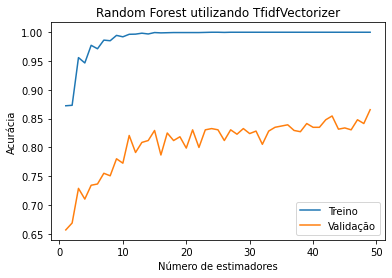

In [21]:
results = []

for vct in ['Count', 'TF-IDF']:
    param_metrics = {}
    iters = range(1, 50)
    vectorizer = CountVectorizer() if vct is 'Count' else TfidfVectorizer()
    
    train_acc = []
    val_acc = []
    
    print('\nCodificação:', vct)
    print('Validando Random Forest para diferentes iterações...')
    for i in tqdm(iters):
        clf = RandomForestClassifier(n_estimators=i)
            
        param_metrics[h] = validate_classifier(clf, vectorizer)
        train_acc.append(param_metrics[h]['Train Accuracy'])
        val_acc.append(param_metrics[h]['Validation Accuracy'])
    
    results.append([train_acc, val_acc])
    
train_acc = results[0][0]
val_acc = results[0][1]
plot_accuracy('Random Forest utilizando CountVectorizer', 'Número de estimadores', iters, train_acc, val_acc)

train_acc = results[1][0]
val_acc = results[1][1]
plot_accuracy('Random Forest utilizando TfidfVectorizer', 'Número de estimadores', iters, train_acc, val_acc)

## 5.7) Naive Bayes

In [22]:
tables = []
    
for vct in ['Count', 'TF-IDF']:
    param_metrics = {}
    vectorizer = CountVectorizer() if vct is 'Count' else TfidfVectorizer()
    
    print('\nCodificação:', vct)
    print('Validando Naive Bayes...')
    clf = GaussianNB()
    param_metrics[vct] = validate_classifier(clf, vectorizer, naive_bayes=True)

    tables.append(build_table(param_metrics))
    
display(pd.concat(tables))


Codificação: Count
Validando Naive Bayes...

Codificação: TF-IDF
Validando Naive Bayes...


,Train Accuracy,Validation Accuracy,Precision,Recall
Count,0.995624,0.934366,0.919272,0.922243
TF-IDF,0.995624,0.925605,0.928271,0.886595


# 6) Explicabilidade

## 6.1) Divisão entre dados de treino e teste

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

print('------------------------')
print('Tamanho de X_train:', len(X_train))
print('Tamanho de y_train:', len(y_train))
print('------------------------')
print('Tamanho de X_test:', len(X_test))
print('Tamanho de y_test:', len(y_test))
print('------------------------')

------------------------
Tamanho de X_train: 731
Tamanho de y_train: 731
------------------------
Tamanho de X_test: 183
Tamanho de y_test: 183
------------------------


## 6.2) Melhor modelo

- Através dos resultados vistos na seção 5 (Classificação), temos como melhor modelo o SVM de kernel linear utilizando uma codificação TF-IDF.

In [24]:
vec = TfidfVectorizer()
clf = SVC(kernel='linear', probability=True)

svm_pipe = make_pipeline(vec, clf)
svm_pipe.fit(X_train, y_train)
print('Acurácia do classificador no conjunto de teste:', svm_pipe.score(X_test, y_test))

Acurácia do classificador no conjunto de teste: 0.9344262295081968


## 6.3) O que o melhor modelo aprendeu?

- Nessa seção usarei 3 exemplos de histórias presentes no conjunto de testes para mostrar a importância de cada ``feature`` na predição do modelo, sendo elas: a primeira história do conjunto de testes, uma da ``Marvel Comics`` e uma da ``DC Comics``. Para essa análise irei utilizar a biblioteca ``ELI5``, que é um pacote que ajuda à depurar classificadores explicando as suas predições.<br><br>

- Como experimento, irei retirar algumas features importantes a fim de verificar a variação na acurácia e confiabilidade do modelo.

In [25]:
def explain(doc, pipe):
    """ Função para explicar a predição do modelo dado um documento """
    te = TextExplainer(random_state=42)
    te.fit(doc, pipe.predict_proba)
    print(te.metrics_)
    display(te.show_prediction(target_names=['Marvel Comics', 'DC Comics'], top=25))

### 6.3.1) Primeira história do conjunto de testes

- Nome do personagem: Vox (Malcolm Duncan)
- Criadora: DC Comics

In [26]:
doc = X_test[0]
print(doc)

malcolm duncan wielder gabriel horn bumblebee husband


In [27]:
explain(doc, svm_pipe)

{'mean_KL_divergence': 0.0038295281834036547, 'score': 1.0}


In [28]:
doc2 = re.sub(r'(wielder|gabriel)', '', doc, flags=re.I)
explain(doc2, svm_pipe)

{'mean_KL_divergence': 0.0006671859937959391, 'score': 0.9717956407444198}


### 6.3.2) História da Marvel Comics

- Nome do personagem: J. Jonah Jameson (chefe do Peter Parker)
- Criadora: Marvel Comics

In [29]:
for doc in X_test:
    if 'jameson' in doc:
        break
        
print(doc)

jameson head daily bugle go smear campaign spiderman say spiderman menace become peter parker bos peter able provide closeup photo spiderman peter parker decide retire spiderman jameson acquire spiderman suit found garbage man garbage hung office take back spiderman decide return crimefighting


In [30]:
explain(doc, svm_pipe)

{'mean_KL_divergence': 0.0059697111263322415, 'score': 0.9897208174679114}


In [31]:
doc2 = re.sub(r'(spiderman|peter|parker|jameson)', '', doc, flags=re.I)
explain(doc2, svm_pipe)

{'mean_KL_divergence': 0.005418585614951854, 'score': 0.9589244956518373}


### 6.3.3) História da DC Comics

- Nome do personagem: Penguin (Oswald Chesterfield Cobblepot)
- Criadora: DC Comics

In [32]:
for doc in X_test:
    if 'penguin' in doc:
        break
        
print(doc)

born oswald chesterfield cobblepot penguin tease much childhood due short stature obesity birdlike nose trait make outcast rich debutante family rejection drove become violent criminal least one origin story claim penguin mother own pet shop become criminal neighborhood bully murder animal shop include beloved bird keep family tradition wealth penguin life life crime evil yet executes self proclaim high society class style commits crime theme various bird love unlike batman villain penguin gentleman villain control action perfectly sane lends unique relationship archenemy batman extend current situation penguin cease direct involvement crime instead run nightclub popular underworld excellent source information crime batman grudgingly tolerates operation however entrepreneurial penguin nt exactly keep beak clean often fence steal property arrange early furlough incarcerate former criminal associate hefty fee course side period gotham city level earthquake man land storyline one major pl

In [33]:
explain(doc, svm_pipe)

{'mean_KL_divergence': 0.01072043012739781, 'score': 0.9911730618513457}


In [34]:
doc2 = re.sub(r'(batman|bird|crime|gotham|city)', '', doc, flags=re.I)
explain(doc2, svm_pipe)

{'mean_KL_divergence': 0.016340619344168354, 'score': 0.9764144840290396}


## 6.4) Explicabilidade através de uma Árvore de Decisão

In [35]:
for doc in X_test:
    if 'jameson' in doc:
        break

# Altura 2 apenas por motivos de visualização
te = TextExplainer(clf=DecisionTreeClassifier(max_depth=2), random_state=42)
te.fit(doc, svm_pipe.predict_proba)
print(te.metrics_)
te.show_weights()

{'mean_KL_divergence': 0.013650981065228739, 'score': 0.9831842998412545}


Weight,Feature
0.5871,spiderman
0.4129,peter
0,hung
0,head daily
0,head
0,go smear
0,go
0,garbage man
0,garbage hung
0,crimefighting
